# Predictive Modeling - pKa edition

Today, we delve into the application of regression analysis in chemistry and data science.
Our dataset comprises p$K_\text{a}$ values and corresponding molecular descriptors, offering a quantitative approach to understanding molecular properties.

## pKa

The p$K_\text{a}$ measures a substance's acidity or basicity, particularly in chemistry.
It is the negative logarithm (base 10) of the acid dissociation constant ($K_\text{a}$) of a solution.
The p$K_\text{a}$ value helps quantify the strength of an acid in a solution.

The expression for the acid dissociation constant ($K_\text{a}$), from which p$K_\text{a}$ is derived, is given by the following chemical equilibrium equation for a generic acid (HA) in water:

$$
\text{HA} \rightleftharpoons \text{H}^+ + \text{A}^-
$$

The equilibrium constant ($K_\text{a}$) for this reaction is defined as the ratio of the concentrations of the dissociated ions ($\text{H}^+$ and $\text{A}^-$) to the undissociated acid ($\text{HA}$):

$$
K_a = \frac{[\text{H}^+][\text{A}^-]}{[\text{HA}]}
$$

Taking the negative logarithm (base 10) of both sides of the equation gives the expression for pKa:

$$
\text{p}K_a = -\log_{10}(K_a)
$$

So, in summary, the p$K_\text{a}$ is calculated by taking the negative logarithm of the acid dissociation constant ($K_\text{a}$) for a given acid.
A lower p$K_\text{a}$ indicates a stronger acid.

In simpler terms:

-   A lower p$K_\text{a}$ indicates a stronger acid because it means the acid is more likely to donate a proton (H+) in a chemical reaction.
-   A higher p$K_\text{a}$ indicates a weaker acid as it is less likely to donate a proton.

The p$K_\text{a}$ is a crucial parameter in understanding the behavior of acids and bases in various chemical reactions.
It is commonly used in fields such as medicinal chemistry, biochemistry, and environmental science to describe and predict the behavior of molecules in solution.

## Exploring the dataset

Now, let's shift our focus to a practical application of our theoretical knowledge.

I found [this dataset](https://github.com/IUPAC/Dissociation-Constants) that contains a bunch of high-quality experimental measurements of pKas.
It contains a bunch of information and other aspects that makes regression a bit of a nightmare; thus, I did some cleaning of the data and computed some molecular features (i.e., descriptors) that we can use.
Before delving into regression analysis, it is essential to conduct a systematic review of the dataset.
This preliminary examination will provide us with the necessary foundation to understand the quantitative relationships between molecular features and acidity.
Let's now proceed with a methodical investigation of the empirical data, setting the stage for our subsequent analytical endeavors.

### Loading

Using the Pandas library, read the CSV file into a DataFrame.
Use the variable you defined in the previous step.

In [ ]:
import numpy as np
import pandas as pd

# @title

from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import py3Dmol


def show_mol(smi, style="stick"):
    mol = Chem.MolFromSmiles(smi)
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.MMFFOptimizeMolecule(mol, maxIters=200)
    mblock = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=500, height=500)
    view.addModel(mblock, "mol")
    view.setStyle({style: {}})
    view.zoomTo()
    view.show()

In [34]:
CSV_PATH = "https://github.com/oasci-courses/pitt-biosc1540-2024f/raw/refs/heads/main/content/lectures/21/smiles-pka-desc.csv"

df = pd.read_csv(CSV_PATH)

In [131]:
mol_example = df.iloc[644]  # Sarcosine
print(mol_example["SMILES"])

CNCC(=O)O


[PubChem](https://pubchem.ncbi.nlm.nih.gov/)

In [130]:
show_mol(mol_example["SMILES"])

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Molecular descriptors

Molecular descriptors are quantitative representations of chemical compounds that capture various structural, electronic, and physicochemical properties.
These descriptors are numerical values or sets of values that encode information about the characteristics of a molecule.
Molecular descriptors provide a structured and standardized way to quantify molecular features, facilitating the analysis and comparison of different molecules in chemical and computational studies.

Molecular descriptors can include a wide range of information.


Structural Descriptors: These describe the geometry and connectivity of atoms within a molecule.
Examples include molecular weight, size, and shape descriptors.

Topological Descriptors: These capture information about the connectivity of atoms in a molecular structure, often expressed as graphs or matrices.

Electronic Descriptors: These reflect the electronic properties of a molecule, including features related to electron distribution, charge, and orbital energies.

Physicochemical Descriptors: These encompass properties such as solubility, partition coefficients, and melting points, providing insights into the physical behavior of the molecule.

Quantum Chemical Descriptors: These are derived from quantum mechanical calculations and provide detailed information about a molecule's electronic structure and energetics.

Molecular descriptors are crucial in quantitative structure-activity relationship (QSAR) studies, computational chemistry, and drug design.
By converting complex molecular structures into numerical values, researchers can apply statistical and computational techniques to analyze and model the relationships between molecular features and various properties or activities.

### Histograms

Use Matplotlib's `plt.subplots() `function to create a single subplot.
Assign the returned figure and axis objects to variables (`fig` and `ax`, respectively).

Utilize the `ax.hist()` function to plot a histogram.
Use the `"pka_value"` column from the DataFrame (`df`) as the data, and set the number of bins to `100`.
Choose a `color` for the bars.

Set labels for the x-axis and y-axis using `ax.set_xlabel()` and `ax.set_ylabel()` functions.

Finally, use `plt.show()` to display the histogram.

In [4]:
import matplotlib.pyplot as plt

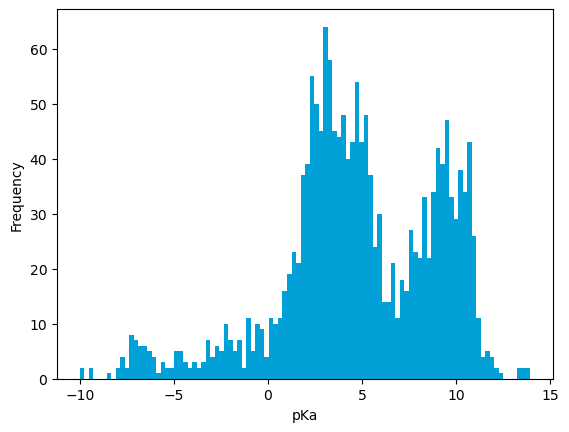

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ax.hist(df["pka_value"], bins=100, color="#01a0d7")

ax.set_xlabel("pKa")
ax.set_ylabel("Frequency")

plt.show()

### Scatter

Use Matplotlib's `plt.subplots()` function to create a single subplot.
Assign the returned figure and axis objects to variables (`fig` and `ax`, respectively).
Utilize the `ax.scatter()` function to plot a scatter plot.
Specify the x-axis data as `"MaxEStateIndex"` and the y-axis data as `"pka_value"` from your DataFrame (`df`).
Choose a color for the scatter points.

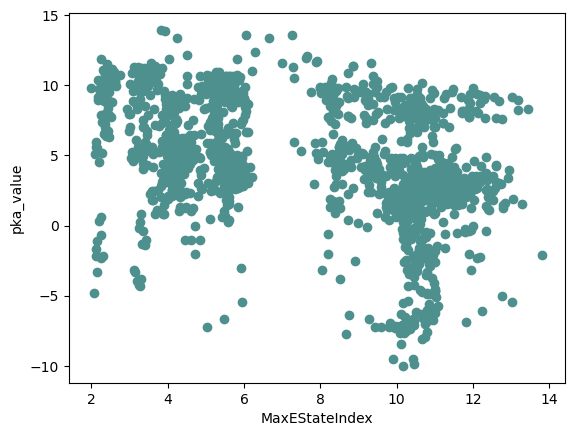

In [6]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ax.scatter(df["MaxEStateIndex"], df["pka_value"], color="#4d908e")

ax.set_xlabel("MaxEStateIndex")
ax.set_ylabel("pka_value")

plt.show()

MaxEStateIndex comes from the work by Lemont Kier and Lowell Hall that we see in [this paper](https://link.springer.com/article/10.1023/A:1015952613760).
The EState descriptors combine both electronic and topological features of atoms in molecules.
The EState value (S) for each atom is calculated using two main components:

1. The intrinsic state value (I) based on electron configuration and topology
2. A field effect (ΔI) from other atoms in the molecule

For any atom, S = I + ΔI

The intrinsic state value I is calculated as:

I = (δv + 1)/δ

where:

- δv is the number of valence electrons
- δ is the number of sigma electrons (representing topological connections)

The MaxEStateIndex that we are using in RDKit represents the highest EState value found for any atom in the molecule.
This value is particularly interesting because:

1. High EState values indicate atoms that are both electronically rich and topologically accessible. Looking at Table I in the paper, we can see that atoms like fluorine (-F) and oxygen (-O) tend to have high intrinsic state values.
2. The maximum value often corresponds to the most reactive or chemically important sites in the molecule. For example, in drug-like molecules, it might highlight potential hydrogen bond acceptors or electronically rich regions that could interact with targets.
3. The value incorporates both electronic effects (through the valence electron count) and structural position (through the sigma electron count and perturbation terms), making it a more complete descriptor than either electronic or topological measures alone.


Use Matplotlib's `plt.subplots()` function to create a single subplot.
Assign the returned figure and axis objects to variables (`fig` and `ax`, respectively).
Utilize the `ax.scatter()` function to plot a scatter plot.
Specify the x-axis data as `"SPS"` and the y-axis data as `"pka_value"` from your DataFrame (`df`).
Choose a color for the scatter points.

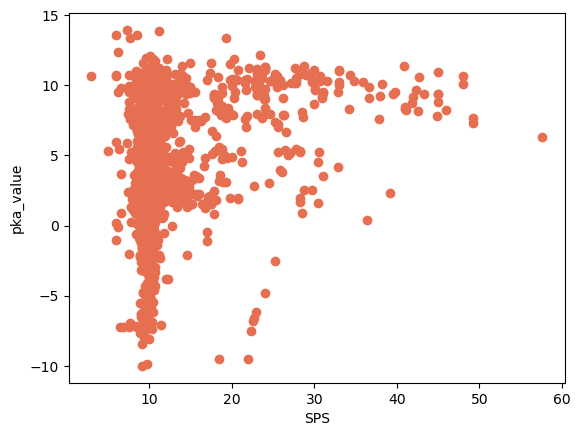

In [7]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ax.scatter(df["SPS"], df["pka_value"], color="#e76f51")

ax.set_xlabel("SPS")
ax.set_ylabel("pka_value")

plt.show()

Use the `ax.scatter()` function to create a scatter plot.
Specify the x-axis data as "SPS" and the y-axis data as `"MaxEStateIndex"` from your DataFrame (`df`).

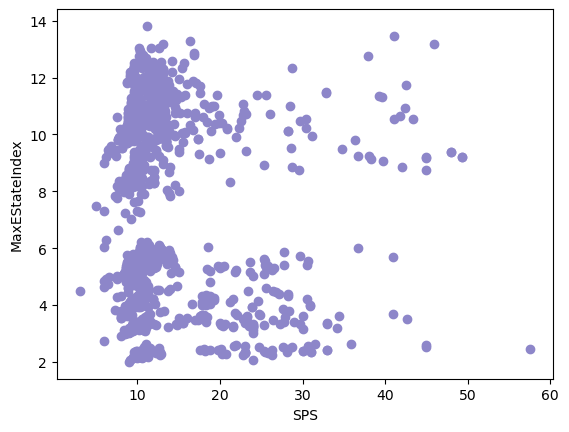

In [8]:
fig, ax = plt.subplots(ncols=1, nrows=1)

ax.scatter(df["SPS"], df["MaxEStateIndex"], color="#8d86c9")

ax.set_xlabel("SPS")
ax.set_ylabel("MaxEStateIndex")

plt.show()

Spacial score (SPS) is an empirical scoring system to express the spacial complexity of a compound in an uniform manner and on a highly granular scale for ranking and comparison between molecules.

## Prediction

Our objective is to predict pKa values using a machine learning model.
In order to do this, we need to prepare our data for training and testing.
Identify the features and target variable.
In this case, the features are the molecular descriptors, and the target variable is the pKa value.
Create separate dataframes for `df_features` and `df_targets`.

In [9]:
df_features = df.drop(columns=["SMILES", "pka_value"], inplace=False)
df_targets = df["pka_value"]

The target variable (`df_targets`) and features (`df_features`) need to be converted into NumPy arrays for compatibility with machine learning models.

In [12]:
targets = df_targets.to_numpy().reshape(-1, 1)
features = df_features.to_numpy()

### Linear model

Create an instance of the `LinearRegression` model from scikit-learn.
Use the `fit` method to train the linear regression model with your features and target variable.

In [10]:
from sklearn.linear_model import LinearRegression

In [13]:
model_linear = LinearRegression()
model_linear.fit(X=features, y=targets)

LinearRegression()

Use the score method to calculate and print the coefficient of determination ($R^2$) of the linear regression model.

In [14]:
linear_score = model_linear.score(X=features, y=targets)

print(linear_score)

0.6043701250852311


Use the predict method to generate predictions (predictions) based on the trained linear regression model and the input `features`.
Create a scatter plot where the x-axis represents the actual pKa values (`targets`), the y-axis represents the predicted pKa values (`predictions`).

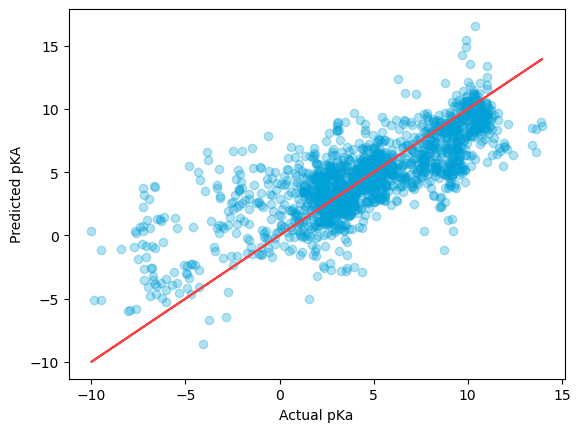

In [15]:
predictions = model_linear.predict(features)

plt.scatter(targets, predictions, color="#01a0d7", alpha=0.3)
plt.plot(targets, targets, linestyle="-", color="#f94144")  # Diagonal line for parity

# Set labels and title
plt.xlabel("Actual pKa")
plt.ylabel("Predicted pKA")

# Display the plot
plt.show()

Points close to the diagonal line indicate accurate predictions, while deviations suggest discrepancies between actual and predicted values.

#### Sanity check

Let's take a look at the coefficients and probe our model.

Extracted from the columns of `df_features`, representing the names of the features.
Obtain the coefficients obtained from the trained linear regression model.

Use `ax.barh()` to create a horizontal bar graph. Feature names are on the y-axis, and corresponding coefficients are on the x-axis.
Add a vertical dashed line (`ax.axvline()`) at zero for reference.

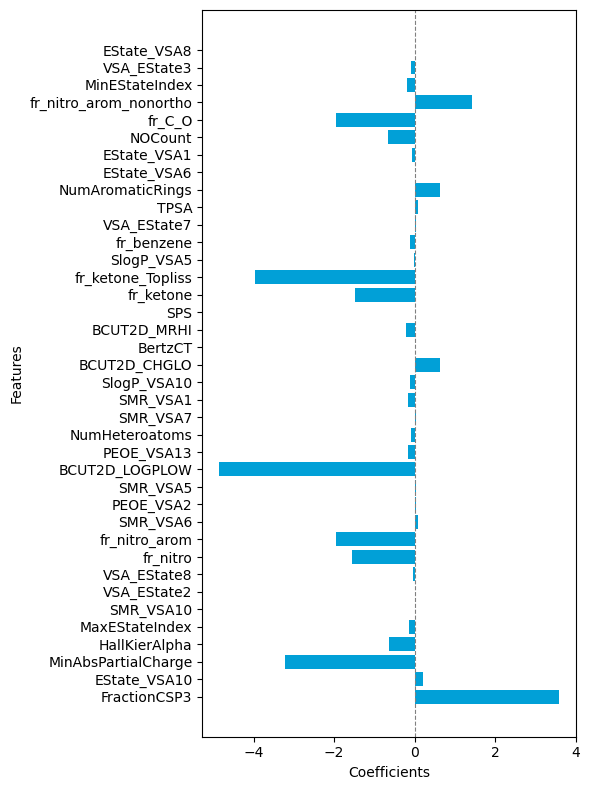

In [16]:
feature_names = df_features.columns
coefficients = model_linear.coef_

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 8))

# Create a horizontal bar graph for coefficients
ax.barh(feature_names, coefficients[0], color="#01a0d7")
ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.8)

# Set labels and title
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

Do these coefficients make sense?

No, they do not because we did not normalize our features!
This means that if the actual values are on different scales the coefficients would be biased.
Let's take a look at our mean and standard deviations.

In [18]:
print(f"Mean: {np.mean(features, axis=0)}")
print(f"Stdev: {np.std(features, axis=0)}")

Mean: [ 3.89086263e-01  3.42564562e+00  1.51257789e-01 -1.05552793e+00
  7.38850665e+00  9.87474283e+00  6.39792696e+00  2.17379462e+00
  9.26143025e-02  8.96834701e-02  8.66622254e+00  3.75190311e+00
  1.29000927e+01 -2.07702217e+00  7.98785771e-01  2.91266120e+00
  2.44354749e+01  5.02232662e+00  2.91767543e+00 -2.03011445e+00
  2.67512213e+02  5.91485540e+00  1.25464017e+01  2.87221571e-02
  2.40328253e-02  1.20706499e+01  6.38335287e-01  1.49691721e+00
  4.19402403e+01  9.92966002e-01  6.19722994e+00  3.42954642e+00
  2.60609613e+00  3.03048066e-01  4.68933177e-02  1.42658643e-02
  4.79929278e+00  1.32189220e+01]
Stdev: [3.48214967e-01 5.20828607e+00 1.19794316e-01 6.92044494e-01
 3.14329063e+00 9.42009878e+00 7.26911371e+00 2.76371970e+00
 3.53650317e-01 3.50245626e-01 9.40709368e+00 4.78250729e+00
 1.66353109e+01 2.36250238e-01 2.42735662e+00 1.78570370e+00
 1.93330859e+01 6.39305630e+00 4.69360336e+00 1.47273625e-01
 1.88615883e+02 1.34002304e+00 6.27599129e+00 1.73901871e-01
 1

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
features_normed = scaler.fit_transform(features)
print(np.mean(features_normed, axis=0))
print(np.std(features_normed, axis=0))

[0.38908626 0.0974926  0.2948773  0.6295543  0.45595543 0.1840046
 0.12020514 0.2083178  0.03087143 0.02989449 0.13191387 0.10677777
 0.05882026 0.56739454 0.03477618 0.22405086 0.23927633 0.13173108
 0.10556195 0.39675025 0.20619666 0.22480559 0.17484252 0.01436108
 0.02403283 0.05503827 0.21277843 0.21619478 0.20385069 0.1985932
 0.11005159 0.05734334 0.21717468 0.06060961 0.02344666 0.74385482
 0.12406237 0.14266253]
[0.34821497 0.14822589 0.23415465 0.15209769 0.26597359 0.17553283
 0.12067985 0.15586012 0.11788344 0.11674854 0.14319113 0.13610839
 0.07585165 0.14586488 0.10567812 0.13736182 0.18931287 0.16768408
 0.1698153  0.10557701 0.14647901 0.1266979  0.1149449  0.08695094
 0.15315106 0.07049962 0.23135893 0.05384273 0.15146571 0.1718744
 0.15558514 0.12477927 0.14429944 0.12405083 0.1097854  0.1551688
 0.15519603 0.16459119]


In [20]:
model_linear_normed = LinearRegression()
model_linear_normed.fit(X=features_normed, y=targets)

linear_score_normed = model_linear_normed.score(X=features_normed, y=targets)

print(linear_score_normed)

0.6043701250852311


In [21]:
print(linear_score_normed - linear_score)

0.0


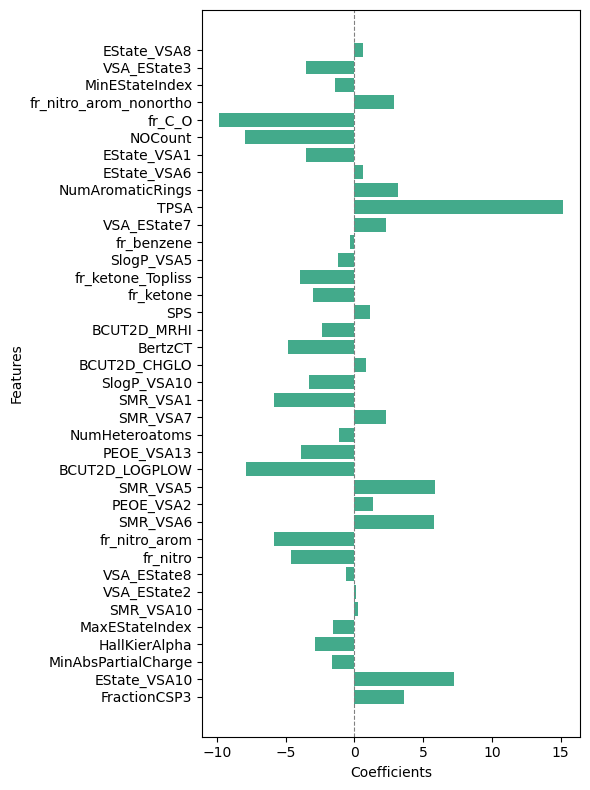

In [22]:
feature_names = df_features.columns
coefficients = model_linear_normed.coef_

fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 8))

# Create a horizontal bar graph for coefficients
ax.barh(feature_names, coefficients[0], color="#43aa8b")
ax.axvline(x=0, color="gray", linestyle="--", linewidth=0.8)

# Set labels and title
ax.set_xlabel("Coefficients")
ax.set_ylabel("Features")

# Adjust layout for better spacing
plt.tight_layout()

# Display the plot
plt.show()

### Neural network (for fun)

We can give up all interpretability if we use a neural network.

In [23]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
# Split the data into training and testing sets

features_train, features_test, targets_train, targets_test = train_test_split(
    features, targets.ravel(), test_size=0.2, random_state=42
)

In [25]:
scaler = StandardScaler()
features_train_scaled = scaler.fit_transform(features_train)
features_test_scaled = scaler.transform(features_test)

In [26]:
model_mlp = MLPRegressor(
    hidden_layer_sizes=(100, 50),
    random_state=42,
    max_iter=1000,
    learning_rate_init=0.01,
    validation_fraction=0.2,
)

model_mlp.fit(X=features_train_scaled, y=targets_train)

MLPRegressor(hidden_layer_sizes=(100, 50), learning_rate_init=0.01,
             max_iter=1000, random_state=42, validation_fraction=0.2)

In [27]:
mlp_score = model_mlp.score(X=scaler.transform(features), y=targets)
print(mlp_score)

0.9467529246044527


In [28]:
model_score_diff = mlp_score - linear_score
print(model_score_diff)

0.34238279951922157


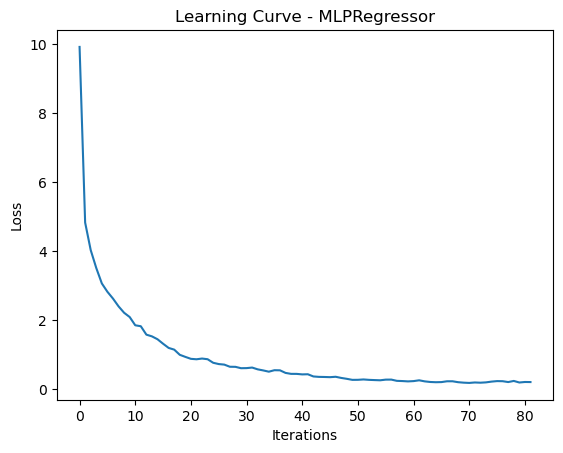

In [29]:
plt.plot(model_mlp.loss_curve_)

# Set labels and title
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.title("Learning Curve - MLPRegressor")

# Display the plot
plt.show()

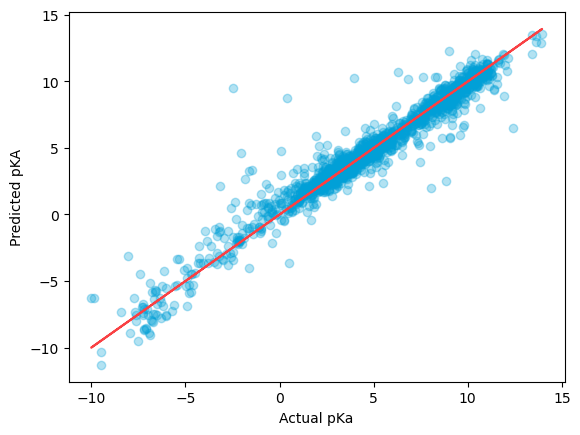

In [30]:
predictions_mlp = model_mlp.predict(scaler.transform(features))

plt.scatter(targets, predictions_mlp, color="#01a0d7", alpha=0.3)
plt.plot(targets, targets, linestyle="-", color="#f94144")  # Diagonal line for parity

# Set labels and title
plt.xlabel("Actual pKa")
plt.ylabel("Predicted pKA")

# Display the plot
plt.show()

Why would we ever use linear regression?

Linear regression is a widely used statistical method for various purposes, with interpretability being a key factor.
When faced with the need to understand the relationship between two variables or predict an outcome based on specific input features, linear regression provides a straightforward and easily interpretable solution.
The simplicity of the linear regression model allows us to analyze and communicate the impact of independent variables on the dependent variable in a straightforward manner.
This transparency is particularly valuable when presenting findings to non-experts or stakeholders who may need help understanding complex statistical models.
Additionally, linear regression provides a solid foundation for further exploration.
It can serve as a baseline model for more sophisticated techniques, making it an essential tool for data analysts and researchers.